In [ ]:
%reset

In [1]:
import numpy as np
import numdifftools as nd
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline 
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from scipy import optimize
np.set_printoptions(precision=25)

In [2]:
from rushisland5 import *

In [ ]:
who

In [3]:
# Pe = Eq*Iq + Ed*Id = Eq*(Vd-Ed)/Xqp + Ed*(Eq-Vq)/Xdp = (Eq*Vd - Ed*Vq)/Xdp
def f_w1(x):
#     Pm = x[14]
#     Pm = 6.8954233610562881
    Pm = 7.5
    Eqp1 = x[0]
    Edp1 = x[1]
    Vd1 = np.real(f_Vdq(x)[0])
    Vq1 = np.imag(f_Vdq(x)[0])
    Pe = (Eqp1*Vd1 - Edp1*Vq1)/Xdp
    return 1 / (2 * H) * (Pm - Pe)


def f_w2(x):
#     Pm = x[15]
#     Pm = 7.5312971941631437
    Pm = 7.3
    Eqp2 = x[7]
    Edp2 = x[8]
    Vd2 = np.real(f_Vdq(x)[1])
    Vq2 = np.imag(f_Vdq(x)[1])
    Pe = (Eqp2*Vd2 - Edp2*Vq2)/Xdp
    return 1 / (2 * H) * (Pm - Pe)


def f_VA1(x):
#     Vref = x[16]
    Vref = 1.0586038003890010
    Eqp1 = x[0]
    Edp1 = x[1]
    Vf1 = x[4]
    Va1 = x[5]
    Ve1 = x[6]
    Id1 = f_Id1(x)
    XadIfd = Eqp1 + (Xd - Xdp) * Id1
    Vfe = KD1 * XadIfd + KE1 * Ve1 + Aex1 * np.exp(Bex1 * Ve1)
    yf = KF1 / TF1 * (Vfe - Vf1)
    Vsum = Vref - np.absolute(f_Vdq(x)[0]) - yf
    return (Vsum - Va1) / TA1


def f_VA2(x):
#     Vref = x[17]
    Vref = 1.0659163034132286
    Eqp2 = x[7]
    Edp2 = x[8]
    Vf2 = x[11]
    Va2 = x[12]
    Ve2 = x[13]
    Id2 = f_Id2(x)
    XadIfd = Eqp2 + (Xd - Xdp) * Id2
    Vfe = KD2 * XadIfd + KE2 * Ve2 + Aex2 * np.exp(Bex2 * Ve2)
    yf = KF2 / TF2 * (Vfe - Vf2)
    Vsum = Vref - np.absolute(f_Vdq(x)[1]) - yf
    return (Vsum - Va2) / TA2


def sys_fun(x):
    fun = [f_Eqp1, f_Edp1, f_delta1, f_w1, f_VF1, f_VA1, f_VE1, f_Eqp2, f_Edp2, f_delta2, f_w2, f_VF2, f_VA2, f_VE2]
    
#     J = np.array([nd.Jacobian(f)(x).ravel() for f in fun])
#     J = J[:,:14]
#     lam, v = np.linalg.eig(J)
#     #lam = lam[abs(lam.imag).argsort()][::-1]
#     print(lam)
#     res = np.append(np.array([f(x).ravel() for f in fun]).ravel(), [lam[4].real,lam[5].real,lam[8].real,lam[9].real])
#     return res

    return np.array([f(x).ravel() for f in fun]).ravel()

all_fun = [f_Eqp1,f_Edp1,f_delta1,f_w1,f_VF1,f_VA1,f_VE1,f_Eqp2,f_Edp2,f_delta2,f_w2,f_VF2,f_VA2,f_VE2]

In [4]:
sys_fun(x)

array([ 2.4470731882357105e-13,  8.9385122874669238e-12,
       -1.9884958138562446e-26,  7.1819510435303545e-03,
       -1.9951834065727452e-12, -2.0335739265359760e-11,
        1.7638312463019153e-12,  1.9021682290575851e-13,
        1.5969425519637771e-11, -3.6531015914904231e-26,
       -2.7476502033722005e-03, -9.3614005436393199e-13,
       -7.4997300036905301e-14,  1.2001795568768359e-12])

In [5]:
sol = optimize.root(sys_fun, x, method='hybr')
all_fun = [f_Eqp1,f_Edp1,f_delta1,f_w1,f_VF1,f_VA1,f_VE1,f_Eqp2,f_Edp2,f_delta2,f_w2,f_VF2,f_VA2,f_VE2]
# J = np.array([nd.Jacobian(f)(sol.x).ravel() for f in all_fun])
J = Jacobian(sol.x)
#display(pd.DataFrame(J))
lam, v = np.linalg.eig(J.T) # Here we want to calculate the left eigenvecs, so use J_org.T; because use left eigvec makes it easier to calc transformation matrix
print(lam)

[-11.079901228541026   +22.510896869694445j
 -11.079901228541026   -22.510896869694445j
  -0.8695790226078204   +8.467289190173808j
  -0.8695790226078204   -8.467289190173808j
   0.03966423260475238  +5.147652230384157j
   0.03966423260475238  -5.147652230384157j
  -6.624418762350323    +0.j
  -4.648470864995127    +0.j
  -0.027462342541130502 +2.0135502059217703j
  -0.027462342541130502 -2.0135502059217703j
  -2.8522499524236524   +0.j
  -1.0493393899177699   +0.9512304001144769j
  -1.0493393899177699   -0.9512304001144769j
  -1.0638673227991124   +0.j                ]


In [6]:
lam[4].real/lam[8].real

-1.4443135193345957

In [ ]:
def Jac(t,x):
    return Jacobian(x)

In [7]:
from scipy.integrate import solve_ivp
def func_ty(t, x): 
    return sys_fun(x)
np.random.seed(1)
fs = 120
tend = 500
# noise = np.random.random_sample((14,))/100
x0 = x
sol = solve_ivp(func_ty, [0,tend], x0, method='RK45', t_eval=np.arange(0,tend,1/fs))

In [16]:
tend = 5000
x0 = sol.y[:,-1]
sol = solve_ivp(func_ty, [0,tend], x0, method='RK45', t_eval=np.arange(0,tend,1/fs))

In [17]:
sol.y.shape

(14, 600000)

In [18]:
data = pd.DataFrame(sol.y.T)

Text(0.5,0,'time(sec)')

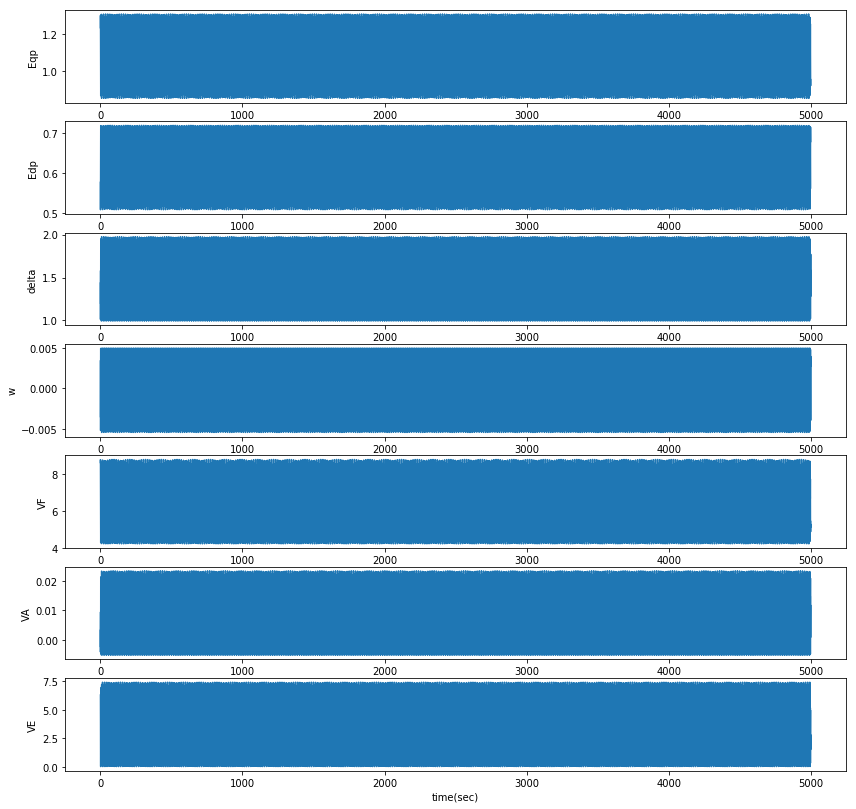

In [19]:
fig, ax = plt.subplots(nrows=7,ncols=1,figsize=(14,14))
start = 0*fs
end = -1
ax[0].plot(sol.t[start:end], data.iloc[start:end,0])
ax[1].plot(sol.t[start:end], data.iloc[start:end,1])
ax[2].plot(sol.t[start:end], data.iloc[start:end,2])
ax[3].plot(sol.t[start:end], data.iloc[start:end,3])
ax[4].plot(sol.t[start:end], data.iloc[start:end,4])
ax[5].plot(sol.t[start:end], data.iloc[start:end,5])
ax[6].plot(sol.t[start:end], data.iloc[start:end,6])
ax[0].set_ylabel('Eqp')
ax[1].set_ylabel('Edp')
ax[2].set_ylabel('delta')
ax[3].set_ylabel('w')
ax[4].set_ylabel('VF')
ax[5].set_ylabel('VA')
ax[6].set_ylabel('VE')
ax[6].set_xlabel('time(sec)')

Text(0.5,0,'time(sec)')

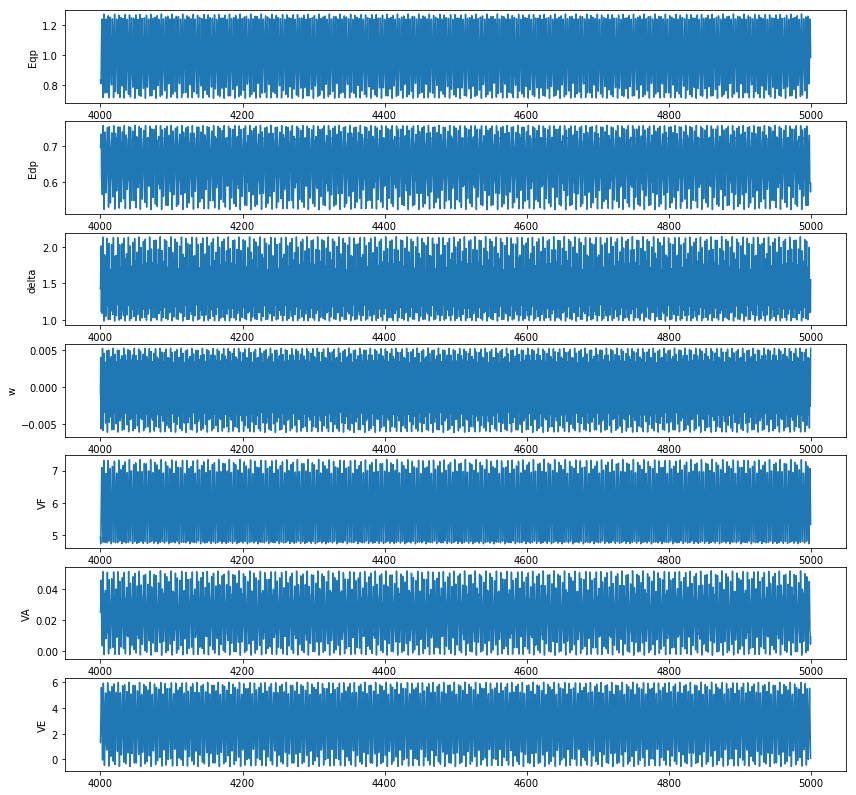

In [20]:
fig, ax = plt.subplots(nrows=7,ncols=1,figsize=(14,14))
start = 4000*fs
end = -1
ax[0].plot(sol.t[start:end:8], data.iloc[start:end:8,7])
ax[1].plot(sol.t[start:end:8], data.iloc[start:end:8,8])
ax[2].plot(sol.t[start:end:8], data.iloc[start:end:8,9])
ax[3].plot(sol.t[start:end:8], data.iloc[start:end:8,10])
ax[4].plot(sol.t[start:end:8], data.iloc[start:end:8,11])
ax[5].plot(sol.t[start:end:8], data.iloc[start:end:8,12])
ax[6].plot(sol.t[start:end:8], data.iloc[start:end:8,13])
ax[0].set_ylabel('Eqp')
ax[1].set_ylabel('Edp')
ax[2].set_ylabel('delta')
ax[3].set_ylabel('w')
ax[4].set_ylabel('VF')
ax[5].set_ylabel('VA')
ax[6].set_ylabel('VE')
ax[3].set_xlabel('time(sec)')

Text(0,0.5,'w2')

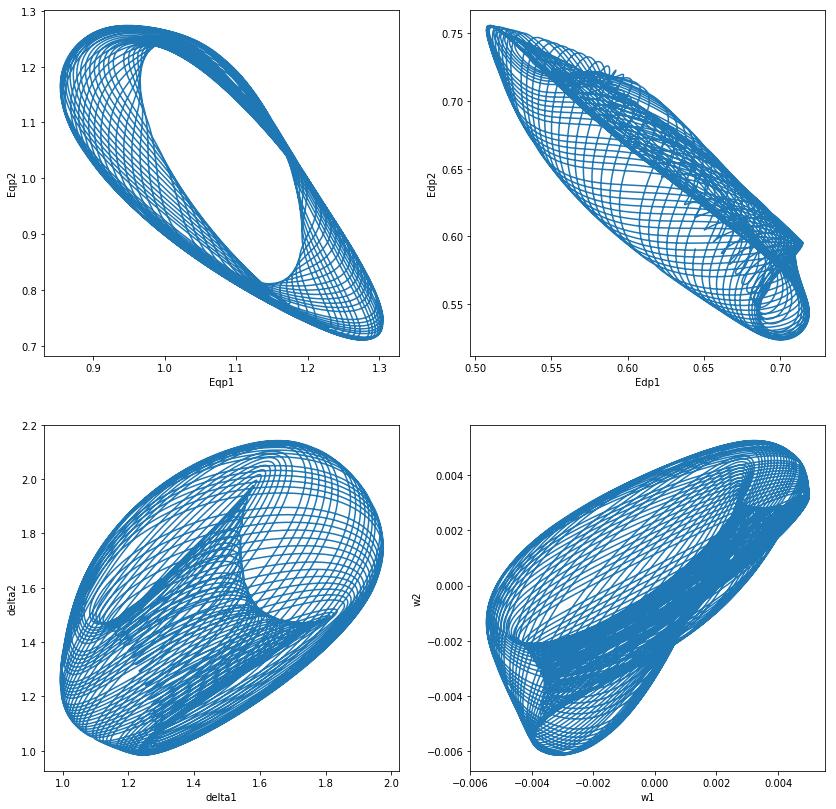

In [21]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,14))
start = 4900 * fs
end = 5000 * fs
ax[0][0].plot(data.iloc[start:end,0],data.iloc[start:end,7]);ax[0][0].set_xlabel('Eqp1');ax[0][0].set_ylabel('Eqp2')
ax[0][1].plot(data.iloc[start:end,1],data.iloc[start:end,8]);ax[0][1].set_xlabel('Edp1');ax[0][1].set_ylabel('Edp2')
ax[1][0].plot(data.iloc[start:end,2],data.iloc[start:end,9]);ax[1][0].set_xlabel('delta1');ax[1][0].set_ylabel('delta2')
ax[1][1].plot(data.iloc[start:end,3],data.iloc[start:end,10]);ax[1][1].set_xlabel('w1');ax[1][1].set_ylabel('w2')